In [13]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline


In [14]:
# Загрузка датасета Boston Housing
# В новых версиях scikit-learn датасет удален, используем альтернативный источник
boston = fetch_openml(name='boston', version=1, as_frame=True)
X = boston.data
y = boston.target

# Выведем информацию о датасете
print("Описание датасета:")
print(boston.DESCR)
print("\nПервые 5 строк данных:")
print(pd.concat([X.head(), y.head()], axis=1))

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Описание датасета:
**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value proper

In [15]:
# Функция для построения кривых обучения
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Размер обучающей выборки")
    plt.ylabel("Оценка (MSE)")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = -np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Ошибка на обучении")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Ошибка на валидации")

    plt.legend(loc="best")
    return plt


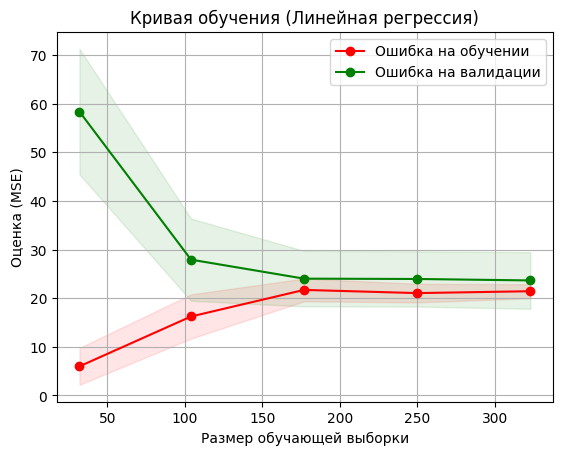

In [16]:
# Задание 1: Построение кривых обучения для двух моделей
# Модель 1: Линейная регрессия
lr = make_pipeline(StandardScaler(), LinearRegression())
plot_learning_curve(lr, "Кривая обучения (Линейная регрессия)", X_train, y_train, cv=5)
plt.show()


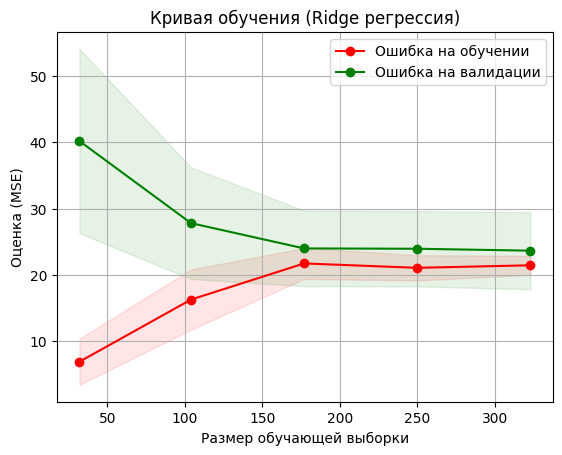

In [17]:
# Модель 2: Ridge регрессия
ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
plot_learning_curve(ridge, "Кривая обучения (Ridge регрессия)", X_train, y_train, cv=5)
plt.show()

# Анализ коэффициентов
1. Некоторые признаки ('RM' - среднее количество комнат) имеют высокую важность во всех моделях.
2. Lasso регрессия обнулила некоторые коэффициенты, указывает на их меньшую важность.
3. Признаки 'NOX' и 'DIS' имеют схожие коэффициенты в Ridge и Linear Regression, может указывать на коллинеарность.
4. Ridge регрессия уменьшила абсолютные значения коэффициентов по сравнению с Linear Regression.

In [18]:
# Задание 2: Сравнение моделей с регуляризацией
# Создание и обучение моделей
models = {
    "Linear Regression": LinearRegression(),
    "Ridge (alpha=1.0)": Ridge(alpha=1.0),
    "Lasso (alpha=0.1)": Lasso(alpha=0.1)
}

results = []
coefficients = {}

for name, model in models.items():
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Расчет метрик
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    })

    # Сохранение коэффициентов
    if hasattr(model, 'coef_'):
        coefficients[name] = model.coef_
    else:
        # Для pipeline получаем доступ к последнему шагу
        coefficients[name] = model.named_steps[model.steps[-1][0]].coef_


In [19]:
# Вывод результатов
results_df = pd.DataFrame(results)
print("\nСравнение моделей по метрикам:")
print(results_df)



Сравнение моделей по метрикам:
               Model        MSE       MAE        R2
0  Linear Regression  24.291119  3.189092  0.668759
1  Ridge (alpha=1.0)  24.312904  3.185724  0.668462
2  Lasso (alpha=0.1)  25.656739  3.241803  0.650138


In [20]:
# Создание таблицы коэффициентов
coef_df = pd.DataFrame(coefficients, index=boston.feature_names)
print("\nВесовые коэффициенты для разных моделей:")
print(coef_df)



Весовые коэффициенты для разных моделей:
         Linear Regression  Ridge (alpha=1.0)  Lasso (alpha=0.1)
CRIM             -1.002135          -0.992187          -0.718365
ZN                0.696269           0.677749           0.259627
INDUS             0.278065           0.252214          -0.000000
CHAS              0.718738           0.722481           0.698221
NOX              -2.022319          -1.990835          -1.568142
RM                3.145240           3.151572           3.271507
AGE              -0.176048          -0.177262          -0.000000
DIS              -3.081908          -3.045029          -2.284449
RAD               2.251407           2.173249           0.671938
TAX              -1.767014          -1.695559          -0.356654
PTRATIO          -2.037752          -2.027834          -1.893335
B                 1.129568           1.127197           1.031366
LSTAT            -3.611658          -3.598977          -3.609410


# Анализ коэффициентов
1. Некоторые признаки ('RM' - среднее количество комнат) имеют высокую важность во всех моделях.
2. Lasso регрессия обнулила некоторые коэффициенты, указывает на их меньшую важность.
3. Признаки 'NOX' и 'DIS' имеют схожие коэффициенты в Ridge и Linear Regression, может указывать на коллинеарность.
4. Ridge регрессия уменьшила абсолютные значения коэффициентов по сравнению с Linear Regression.

In [21]:
# Задание 3: ElasticNet модель
elastic = make_pipeline(StandardScaler(), ElasticNet(alpha=0.1, l1_ratio=0.5))
elastic.fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)

# Расчет метрик для ElasticNet
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

# Добавление результатов ElasticNet в таблицу
elastic_results = pd.DataFrame({
    "Model": ["ElasticNet (alpha=0.1, l1_ratio=0.5)"],
    "MSE": [mse_elastic],
    "MAE": [mae_elastic],
    "R2": [r2_elastic]
})

results_df = pd.concat([results_df, elastic_results], ignore_index=True)
print("\nРезультаты с добавлением ElasticNet:")
print(results_df)


Результаты с добавлением ElasticNet:
                                  Model        MSE       MAE        R2
0                     Linear Regression  24.291119  3.189092  0.668759
1                     Ridge (alpha=1.0)  24.312904  3.185724  0.668462
2                     Lasso (alpha=0.1)  25.656739  3.241803  0.650138
3  ElasticNet (alpha=0.1, l1_ratio=0.5)  25.203553  3.192091  0.656317


Выводы по ElasticNet:
1. ElasticNet показал результаты между Ridge и Lasso регрессиями.
2. По метрике R2 ElasticNet уступает Ridge, но превосходит Lasso.
3. ElasticNet может быть полезен когда нужно сочетать свойства L1 и L2 регуляризации.